In [1]:
from jeroHelper.setupUtils import append_deepfinder_path, get_tomo_indices, PARENT_PATH
append_deepfinder_path()

from jeroHelper.trainHelper import make_trainer
from jeroHelper.coordGen import OLMaker
import deepfinder.utils.objl as ol

from deepfinder.dataloader_pylit import DeepFinder_dataset, to_categorical, transpose_to_channels_first
from deepfinder.utils import core

from jeroHelper.showcaseResults import (predict_fullTomogram, load_model, load_tomoData,
                                        fullTomogram_modelComparison, make_comparison_plot, write_comparison_gif)

import torch
from torch.utils.data import Dataset

from deepfinder.utils.common import read_array

import numpy as np
import matplotlib.pyplot as plt
import random
import mrcfile
import pandas as pd

%matplotlib inline
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

# Tomogram inspection

In [2]:
import SimpleITK as sitk

# mrc_file = PARENT_PATH+'data/processed1/nnUnet/Task143_cryoET7/labelsTr/tomo02_patch001.mrc' # enforced 01
mrc_file = PARENT_PATH+'data/nnUnet/Task143_cryoET7/labelsTr/tomo02_patch030.nii.gz'
labels = read_array(mrc_file)

mrc_file = PARENT_PATH+'data/nnUnet/Task143_cryoET7/imagesTr/tomo02_patch030_0000.nii.gz'
data = read_array(mrc_file)

print(data.shape)

(160, 160, 160)


In [3]:
aux = to_categorical(torch.from_numpy(labels))
aux.shape

torch.Size([160, 160, 160, 3])

In [4]:
aux[:, :, :, 0:2].shape

torch.Size([160, 160, 160, 2])

Text(0.5, 1.0, 'Labelled values')

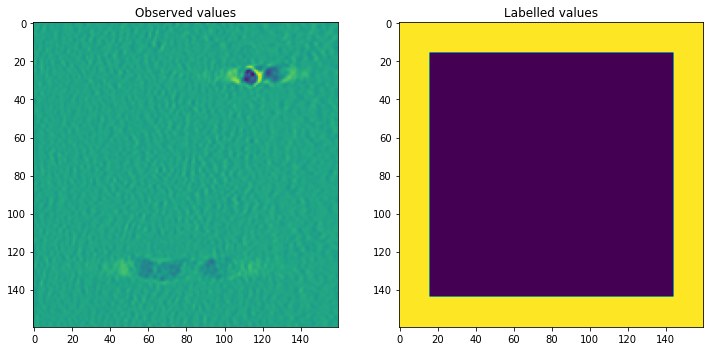

<Figure size 432x288 with 0 Axes>

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 10))
idx_z = 16

plt.figure()
ax1.imshow(data[idx_z])
ax1.set_title('Observed values')
ax2.imshow(labels[idx_z])
ax2.set_title('Labelled values')

In [160]:
zidx, yidx, xidx = np.indices(np.array(labels.shape))
labels_flat = labels.flatten()

coords = list(zip(zidx.flatten(), yidx.flatten(), xidx.flatten()))
df = pd.DataFrame(coords, columns=['z', 'y', 'x'])
df['label'] = labels_flat

In [119]:
myidx = 36
(df[df.z == myidx].label != labels[myidx].flatten()).sum()

0

In [120]:
df.memory_usage(index=True).sum()*1e-6

114.68812799999999

In [101]:
100/len(df[df.label!=2])

0.0005694241982507289

In [107]:
df_sample = df[df.label!=2].groupby('label', group_keys=False).apply(lambda x: x.sample(frac=100/len(df[df.label!=2])))
for i, val in enumerate(df_sample.values):
    i, val
    break

In [162]:
first = df[(df.z==79) & (df.y==79) & (df.x==79)]
first.index[0]

2035119

In [164]:
df[df.index!=2035119]

,z,y,x,label
0,0,0,0,2.0
1,0,0,1,2.0
2,0,0,2,2.0
3,0,0,3,2.0
4,0,0,4,2.0
...,...,...,...,...
4095995,159,159,155,2.0
4095996,159,159,156,2.0
4095997,159,159,157,2.0
4095998,159,159,158,2.0


In [156]:
df_sample.iloc[0]

z        55.0
y        11.0
x        31.0
label     0.0
Name: 173127, dtype: float64

In [172]:
df_sample.iloc[0] = first.values[0]


for i, val in enumerate(df_sample.values):
    val = val.astype(int)
    zyx = val[[0, 1, 2]]
    label = val[3]
    break

In [173]:
zyx

array([79, 79, 79])

In [174]:
label

1

## Mask array tryout 

In [19]:
np.unique(labels, return_counts=True)

(array([0, 1, 2], dtype=uint8), array([1581070,  484265, 2030665]))

In [66]:
labels[labels==2]

array([2, 2, 2, ..., 2, 2, 2], dtype=uint8)

In [24]:
mask = np.where(labels==2, 1, 0)

masked_labels = np.ma.masked_array(labels, mask)

Text(0.5, 1.0, 'Labelled values')

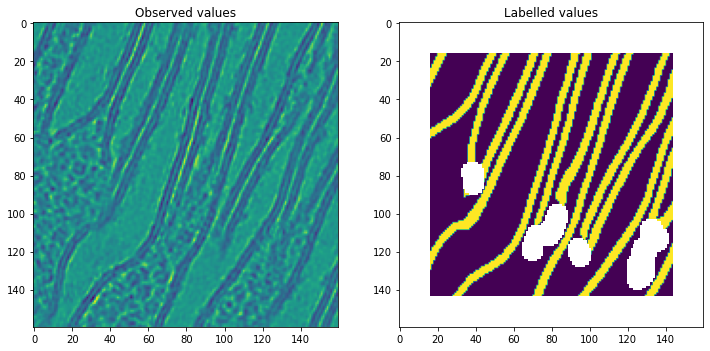

<Figure size 432x288 with 0 Axes>

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 10))
idx_z = 80

plt.figure()
ax1.imshow(data[idx_z])
ax1.set_title('Observed values')
ax2.imshow(masked_labels[idx_z])
ax2.set_title('Labelled values')

In [26]:
np.unique(masked_labels, return_counts=True)

(masked_array(data=[0.0, 1.0, --],
              mask=[False, False,  True],
        fill_value=1e+20,
             dtype=float32),
 array([1581070,  484265, 2030665]))

In [28]:
import torch

In [31]:
np.unique(torch.tensor(masked_labels), return_counts=True)

(array([0., 1., 2.], dtype=float32), array([1581070,  484265, 2030665]))

In [39]:
t_labels = torch.tensor(labels)
t_mask = torch.tensor(mask).type(torch.ByteTensor)

t_labels.masked_select(t_mask).shape

torch.Size([2030665])

In [38]:
t_labels.shape

torch.Size([160, 160, 160])

# Create object lists

In [2]:
train_tomos = ['tomo02', 'tomo03', 'tomo04', 'tomo17']
concat_train_ids = sorted([s.replace('tomo', '') for s in train_tomos])
concat_train_ids = '-'.join(concat_train_ids)

val_tomos = ['tomo32', 'tomo10']
concat_val_ids = sorted([s.replace('tomo', '') for s in val_tomos])
concat_val_ids = '-'.join(concat_val_ids)

test_tomos = ['tomo38']

objectList_maker = OLMaker(train_tomos, val_tomos, test_tomos, 12, 15, 20, None, None)

# objectList_maker.make_xml_objlists(overwrite=True)
# rsample_train, rsample_val = objectList_maker.get_random_samples(500, 300)
# objlist_train, objlist_val = ol.read_xml(objectList_maker.train_objlist_path), ol.read_xml(objectList_maker.val_objlist_path)
# objlist_train, objlist_val = objectList_maker.get_random_samples(500, 300)

Pairs of tomo IDs to indices:
[('tomo02_patch000', 0), ('tomo02_patch001', 1), ('tomo02_patch002', 2), ('tomo02_patch003', 3), ('tomo02_patch004', 4), ('tomo02_patch005', 5), ('tomo02_patch006', 6), ('tomo02_patch020', 7), ('tomo02_patch021', 8), ('tomo02_patch030', 9), ('tomo03_patch000', 10), ('tomo03_patch002', 11), ('tomo03_patch004', 12), ('tomo03_patch006', 13), ('tomo03_patch008', 14), ('tomo03_patch010', 15), ('tomo03_patch020', 16), ('tomo03_patch021', 17), ('tomo03_patch022', 18), ('tomo03_patch030', 19), ('tomo03_patch031', 20), ('tomo03_patch032', 21), ('tomo04_patch000', 22), ('tomo04_patch002', 23), ('tomo04_patch004', 24), ('tomo04_patch006', 25), ('tomo04_patch008', 26), ('tomo04_patch009', 27), ('tomo04_patch020', 28), ('tomo04_patch021', 29), ('tomo04_patch030', 30), ('tomo10_patch001', 31), ('tomo10_patch002', 32), ('tomo10_patch003', 33), ('tomo10_patch009', 34), ('tomo10_patch010', 35), ('tomo10_patch011', 36), ('tomo10_patch020', 37), ('tomo10_patch030', 38), ('to

In [3]:
len(objlist_train), len(objlist_val)

NameError: name 'objlist_train' is not defined

In [ ]:
pd.value_counts([v['label'] for v in objlist_train], normalize=True)

In [40]:
pd.value_counts([v['label'] for v in objlist_val], normalize=True)

0    0.561338
1    0.438662
dtype: float64

## Sanity check: overfit one sample using the `Trainer.launch` method

In [3]:
tb_logdir = './scratchpad_logs/2.06_use_isensee_training_data/'

trainer = make_trainer(dim_in=56, batch_size=32, lr=1e-4, epochs=800, tb_logdir=tb_logdir, model_name='2.06_baselineModelTest',
                       reconstruction_trainer=False, pretrained_model=None, test_run=True)

In [4]:
trainer.Ncl, trainer.augment_data, trainer.epochs

(2, False, 800)

In [5]:
objectList_maker.path_data[0]

'/home/haicu/jeronimo.carvajal/Thesis/data/nnUnet/Task143_cryoET7/imagesTr/tomo02_patch000_0000.nii.gz'

In [6]:
patch_to_overfit = [{'tomo_idx': 0,
 'obj_id': 0,
 'label': 0,
 'x': 79.0,
 'y': 79.0,
 'z': 79.0,
 'psi': None,
 'phi': None,
 'the': None,
 'cluster_size': None}]

val_patch = [{'tomo_idx': 49,
  'obj_id': 0,
  'label': 1,
  'x': 79.0,
  'y': 79.0,
  'z': 79.0,
  'psi': None,
  'phi': None,
  'the': None,
  'cluster_size': None}]

In [7]:
trainer.launch(objectList_maker.path_data, objectList_maker.path_target, patch_to_overfit, val_patch)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]
Set SLURM handle signals.

  | Name    | Type         | Params
-----------------------------------------
0 | loss_fn | Tversky_loss | 0     
1 | layer1  | Sequential   | 28.6 K
2 | layer2  | Sequential   | 103 K 
3 | layer3  | Sequential   | 558 K 
4 | layer4  | Sequential   | 288 K 
5 | layer5  | Sequential   | 96.9 K
-----------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.304     Total estimated model params size (MB)


"Ncl":           2
"loss_fn":       Tversky_loss()
"lr":            0.0001
"pretrain_type": None
"weight_decay":  0.0
Saving model at:  /home/haicu/jeronimo.carvajal/Thesis/models/2.06_baselineModelTest_ep800_in56_lr0.000100_v25.model

Writing to modelSummary...
Opening ModelSummary file...
ModelSummary file exists, appending current model data...


## Visualize

I just wanted to verify that we are overfitting to one sample

In [45]:
model_fileList = [PARENT_PATH+'models/2.06_baselineModelTest_ep800_in56_lr0.000100_v21.model',
                  PARENT_PATH+'models/2.06_baselineModelTest_ep800_in56_lr0.000100_v22.model',
                  PARENT_PATH+'models/2.06_baselineModelTest_ep800_in56_lr0.000100_v15.model',
                  PARENT_PATH+'models/2.06_baselineModelTest_ep800_in56_lr0.000100_v16.model']
n_centers_list = [4, 4, 4, 4]

aux_idx = patch_to_overfit[0]['tomo_idx']

tomo_file = objectList_maker.path_data[aux_idx]
label_file = objectList_maker.path_target[aux_idx]

class1_predDict, dice1_dict, class1, tomogram_data = fullTomogram_modelComparison(model_fileList, n_centers_list, tomo_file, label_file)
print(dice1_dict, '\n')

Tomogram shape:  (160, 160, 160)
Predicting full tomogram using 4 centers...


100%|██████████| 64/64 [00:02<00:00, 22.75it/s]


Saving model predictions...
Predicting full tomogram using 4 centers...


100%|██████████| 64/64 [00:02<00:00, 23.15it/s]


Saving model predictions...
Predicting full tomogram using 4 centers...


100%|██████████| 64/64 [00:02<00:00, 22.94it/s]


Saving model predictions...
Predicting full tomogram using 4 centers...


100%|██████████| 64/64 [00:02<00:00, 22.94it/s]


Saving model predictions...
{'2.06_baselineModelTest_ep800_in56_lr0.000100_v21': tensor([0.6102, 0.4213, 0.0000], device='cuda:0'), '2.06_baselineModelTest_ep800_in56_lr0.000100_v22': tensor([0.6349, 0.5678, 0.0000], device='cuda:0'), '2.06_baselineModelTest_ep800_in56_lr0.000100_v15': tensor([0.6048, 0.4144, 0.0000], device='cuda:0'), '2.06_baselineModelTest_ep800_in56_lr0.000100_v16': tensor([0.6186, 0.4347, 0.0000], device='cuda:0')} 



In [46]:
def make_comparison_plot2(class_predDict, class1, tomogram_data):
    pred_keys = list(class_predDict.keys())
    n_models = len(pred_keys)
    n_cols = n_models + 2
    
    z, y, x = 79, 79, 79
    
    for idx_z in np.arange(0, tomogram_data[z-56//2:z+56//2, y-56//2:y+56//2, x-56//2:x+56//2].shape[0], 15):
        fig, axs = plt.subplots(1, n_cols, figsize=(20, 10))
        
        plt.figure()     
        for i in range(n_cols):
            ax = axs[i]
            if i < n_models:
                name = pred_keys[i]
                ax.imshow(class_predDict[name][z-56//2:z+56//2, y-56//2:y+56//2, x-56//2:x+56//2][idx_z])
                ax.set_title("\n".join(wrap(name.replace('_', ' '), 20)))
            elif i==n_models:
                name = 'Labels'
                ax.imshow(class1[z-56//2:z+56//2, y-56//2:y+56//2, x-56//2:x+56//2][idx_z])
                ax.set_title(name)
                
            elif i==n_models+1:
                name = 'Observed z = %i' %idx_z 
                ax.imshow(tomogram_data[z-56//2:z+56//2, y-56//2:y+56//2, x-56//2:x+56//2][idx_z])
                ax.set_title(name)

        plt.show()
        
    return

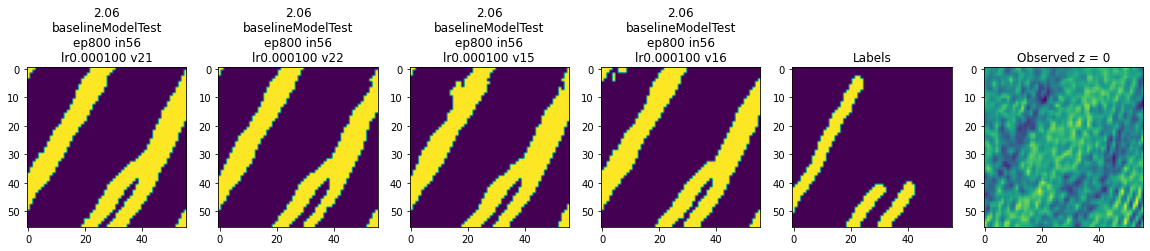

<Figure size 432x288 with 0 Axes>

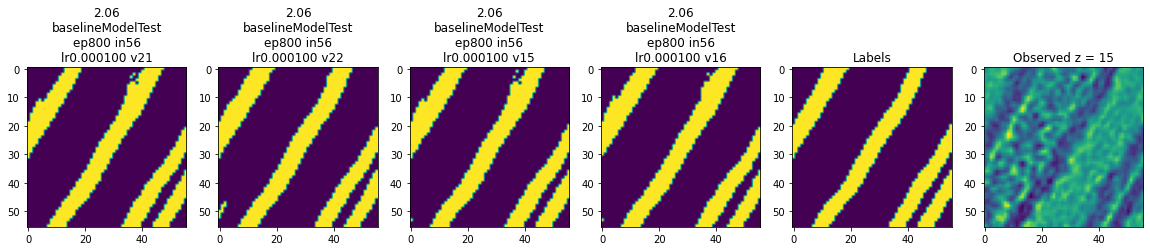

<Figure size 432x288 with 0 Axes>

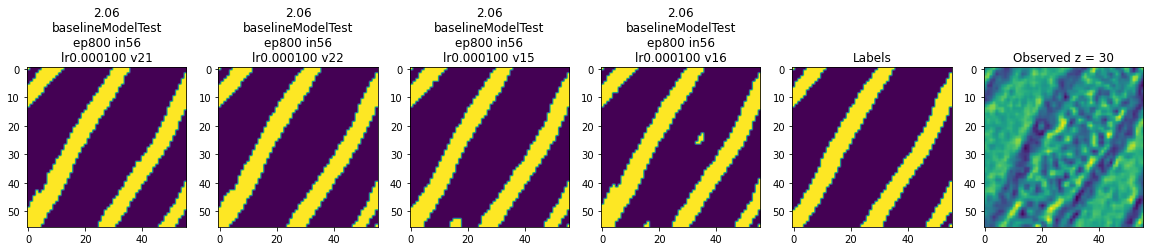

<Figure size 432x288 with 0 Axes>

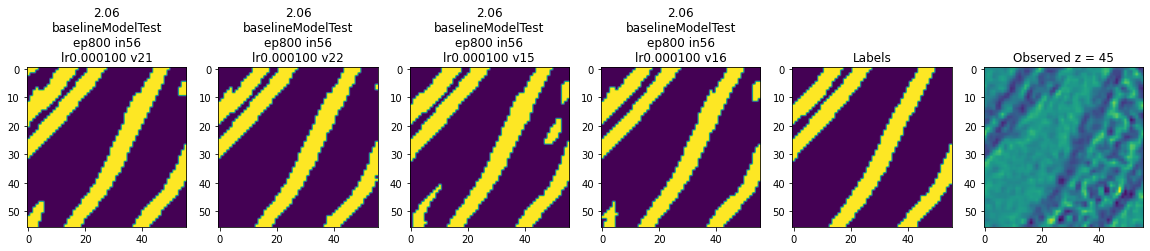

<Figure size 432x288 with 0 Axes>

In [47]:
from textwrap import wrap
make_comparison_plot2(class1_predDict, class1.argmax(0), tomogram_data)

# Data Augmentation

In [8]:
# No data augmentation version
def generate_batch_from_array(index, objlist, data_list, target_list, dim_in, Lrnd, Ncl=2):
    p_in = dim_in//2
    
    batch_data = torch.zeros((dim_in, dim_in, dim_in, 1))

    tomoID = int(objlist[index]['tomo_idx'])

    tomodim = data_list[tomoID].shape

    sample_data = data_list[tomoID]
    sample_target = target_list[tomoID]

    # Get patch position:
    x, y, z = core.get_patch_position(tomodim, p_in, objlist[index], Lrnd)

    # Get patch:
    patch_data = sample_data[z - p_in:z + p_in, y - p_in:y + p_in, x - p_in:x + p_in]
    patch_target = sample_target[z - p_in:z + p_in, y - p_in:y + p_in, x - p_in:x + p_in]

    # Process the patches in order to be used by network:
    # print(patch_data)
    patch_data = (patch_data - torch.mean(patch_data)) / torch.std(patch_data)  # normalize
    patch_target_onehot = to_categorical(patch_target, Ncl)

    # Store into batch array:
    batch_data[:, :, :, 0] = patch_data
    batch_target = patch_target_onehot
        

    batch_data = transpose_to_channels_first(batch_data)
    batch_target = transpose_to_channels_first(batch_target)
    return batch_data, batch_target

In [9]:
flag_direct_read = False
path_data, path_target = objectList_maker.path_data, objectList_maker.path_target
objlist_train = rsample_train
dim_in = 56
Ncl = 2
Lrnd = 0
h5_dset_name = None

train_set = DeepFinder_dataset(flag_direct_read, path_data, path_target, objlist_train, dim_in, 
                               Ncl, Lrnd, h5_dset_name)

In [11]:
my_index = 1
batch_data, batch_target = generate_batch_from_array(my_index, rsample_train, train_set.data_list, train_set.target_list, dim_in, Lrnd)

batch_data = batch_data.squeeze()
batch_target = batch_target[1, :, :, :]

Text(0.5, 1.0, 'Labelled values')

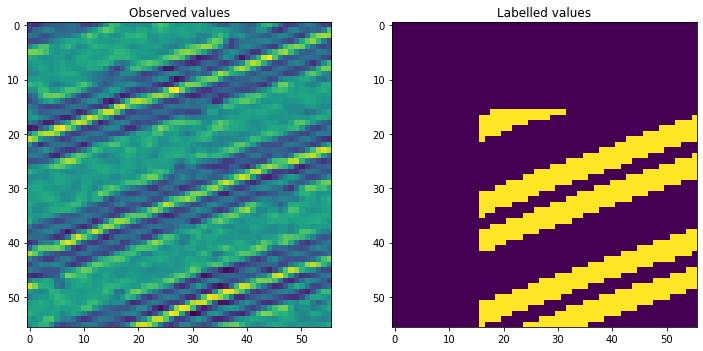

<Figure size 432x288 with 0 Axes>

In [28]:
data, labels = train_set[my_index]

data = data.squeeze()
labels = labels[1, :, :, :]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 10))
idx_z = 18

plt.figure()
ax1.imshow(data[idx_z, :, :])
ax1.set_title('Observed values')
ax2.imshow(labels[idx_z, :, :])
ax2.set_title('Labelled values')

Text(0.5, 1.0, 'Labelled values')

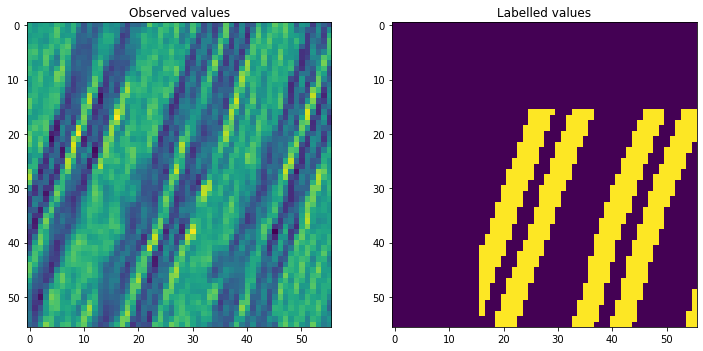

<Figure size 432x288 with 0 Axes>

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 10))

plt.figure()
ax1.imshow(batch_data[idx_z, :, :])
ax1.set_title('Observed values')
ax2.imshow(batch_target[idx_z, :, :])
ax2.set_title('Labelled values')

# New DataLoader (check if it makes sense)

The idea would be to load the patches directly.

In [67]:
class DeepFinder_patchDataset(Dataset):
    def __init__(self, path_data, path_target, dim_in, Ncl):
        self.path_data = path_data
        self.path_target = path_target
        self.dim_in = dim_in
        self.Ncl = Ncl
        self.p_in = np.int(np.floor(self.dim_in / 2))
        self.data_list, self.target_list = core.load_dataset(self.path_data, self.path_target)

    def __len__(self):
        return len(self.objlist)

    def __getitem__(self, idx):
        self.generate_batch_from_array(idx)

    def augment_data(self, batch_data, batch_target):
        np.random.seed(30)
        # 180degree rotation around Y axis
        if np.random.uniform() < 0.5:
            # print('Shifting Y...')
            batch_data = torch.rot90(batch_data, k=2, dims=(0, 2))
            batch_target = torch.rot90(batch_target, k=2, dims=(0, 2))
        # 180degree rotation around X axis
        if np.random.uniform() < 0.5:
            # print('Shifting X...')
            batch_data = torch.rot90(batch_data, k=2, dims=(0, 1))
            batch_target = torch.rot90(batch_target, k=2, dims=(0, 1))
        # rotation between 90 and 270 around Z axis   
        if np.random.uniform() < 0.5:
            k = int(np.random.choice([1, 2, 3]))
            # print('Shifting Z...', k)
            batch_data = torch.rot90(batch_data, k=k, dims=(1, 2))
            batch_target = torch.rot90(batch_target, k=k, dims=(1, 2))
            
        return batch_data, batch_target

    #   batch_data: numpy array [batch_idx, z, y, x, channel] in our case only 1 channel
    #   batch_target: numpy array [batch_idx, z, y, x, class_idx] is one-hot encoded
    def generate_batch(self, index):
        batch_data = torch.zeros((self.dim_in, self.dim_in, self.dim_in, 1))
        
        tomodim = self.data_list[index].shape

        sample_data = self.data_list[index]
        sample_target = self.target_list[index]

        # Get patch position:
        x, y, z = core.get_patch_position(tomodim, self.p_in, self.objlist[index], self.Lrnd)

        # Get patch:
        patch_data = sample_data[z - self.p_in:z + self.p_in, y - self.p_in:y + self.p_in, x - self.p_in:x + self.p_in]
        patch_target = sample_target[z - self.p_in:z + self.p_in, y - self.p_in:y + self.p_in, x - self.p_in:x + self.p_in]

        # Process the patches in order to be used by network:
        # print(patch_data)
        patch_data = (patch_data - torch.mean(patch_data)) / torch.std(patch_data)  # normalize
        patch_target_onehot = to_categorical(patch_target, self.Ncl)

        # Store into batch array:
        batch_data[:, :, :, 0] = patch_data
        batch_target = patch_target_onehot
        
        ### Disable data augmentation to run overfitting to one sample
        ############## Data augmentation #############################
        batch_data, batch_target = self.augment_data(batch_data, batch_target)

        batch_data = transpose_to_channels_first(batch_data)
        batch_target = transpose_to_channels_first(batch_target)

        return batch_data, batch_target

In [79]:
train_set.data_list[0]

tensor([[[-7.7017e-02, -1.0542e-01, -4.0767e-01,  ...,  4.2651e-01,
           1.4463e-01, -5.5605e-01],
         [ 3.7997e-01, -1.4876e-01, -2.8602e-01,  ...,  2.1153e-01,
           2.2045e-01, -2.8556e-01],
         [ 1.1397e+00,  1.1193e-01, -3.3024e-01,  ..., -2.5308e-01,
           1.2121e-01,  1.5808e-02],
         ...,
         [-5.8726e-01,  7.6414e-01,  1.0628e+00,  ...,  1.4825e-01,
           6.9160e-01,  5.1733e-01],
         [-2.0384e-01,  1.2340e+00,  6.8792e-01,  ..., -2.6508e-01,
           9.3672e-01,  9.1128e-01],
         [ 3.1926e-01,  8.2969e-01,  1.7898e-02,  ..., -1.9557e-01,
           2.6197e-01,  7.1181e-01]],

        [[ 1.0827e-01,  5.1996e-01, -2.0817e-01,  ...,  4.5857e-01,
           4.4797e-01, -6.4239e-01],
         [ 1.4629e-01,  4.7230e-02, -2.4072e-01,  ...,  2.5713e-01,
           7.9642e-01, -3.2427e-01],
         [ 8.2329e-01, -6.0939e-02, -4.2716e-01,  ..., -1.1737e-01,
           7.6731e-01, -2.0081e-01],
         ...,
         [-4.3070e-01,  7

In [68]:
flag_direct_read = False
path_data, path_target = objectList_maker.path_data, objectList_maker.path_target
objlist_train = rsample_train
dim_in = 56
Ncl = 2
Lrnd = 0
h5_dset_name = None

train_set = DeepFinder_dataset(flag_direct_read, path_data, path_target, objlist_train, dim_in, 
                               Ncl, Lrnd, h5_dset_name)

In [70]:
my_index = 1
batch_data, batch_target = train_set.generate_batch_from_array(my_index)

batch_data = batch_data.squeeze()
batch_target = batch_target[1, :, :, :]

Text(0.5, 1.0, 'Labelled values')

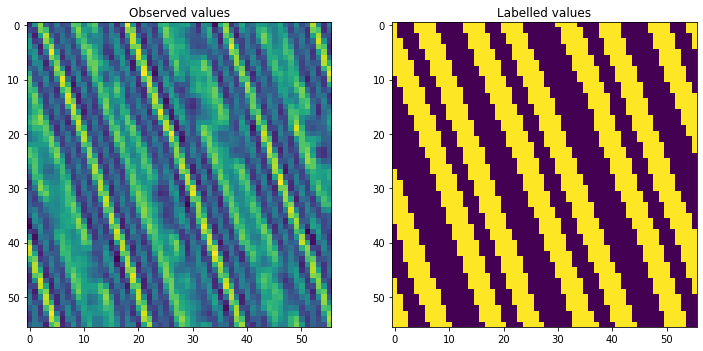

<Figure size 432x288 with 0 Axes>

In [71]:
data, labels = train_set[my_index]

data = data.squeeze()
labels = labels[1, :, :, :]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 10))
idx_z = 18

plt.figure()
ax1.imshow(data[idx_z, :, :])
ax1.set_title('Observed values')
ax2.imshow(labels[idx_z, :, :])
ax2.set_title('Labelled values')